## Experimental method for anomaly detection <br> 
### (using the credit card fraud dataset)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Content
The dataset (from kaggle.com) contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for <b>0.172%</b> of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv(r'c:/Users/User/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

#### Clean DataSet. no Null values

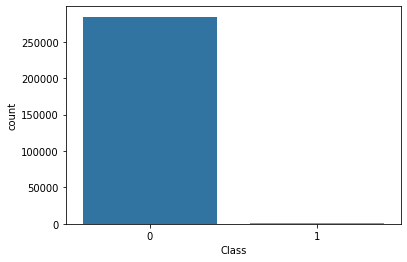

In [5]:
# Class: 1 fraud, 0 not fraud
sns.countplot(x='Class',data=df)
plt.show();

In [6]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

#### Only 0.172% for class 1 (1.72 fraudulent transactions in every 1000 entities).

### <u>Features distribution</u>

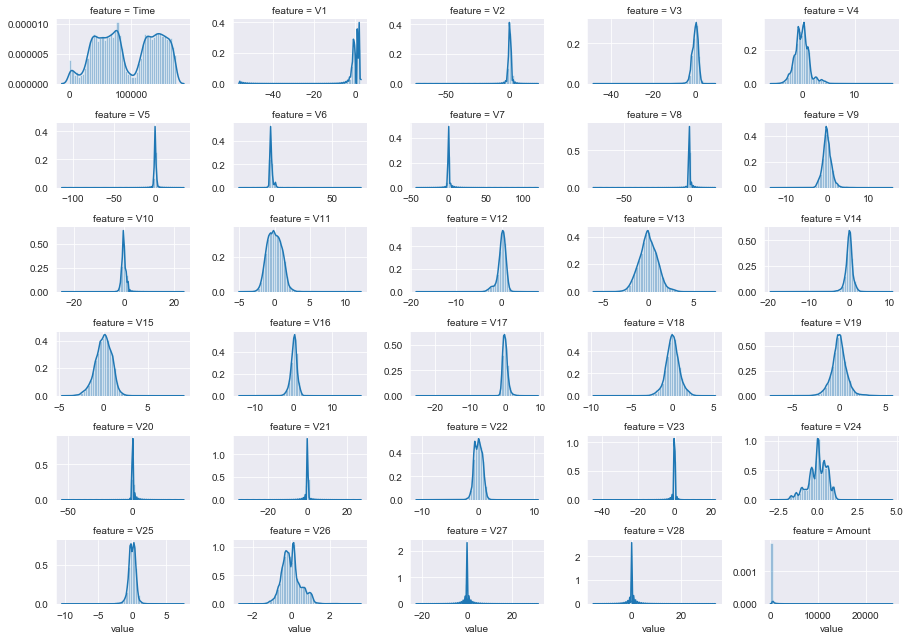

In [7]:
sns.set_style('darkgrid')
features_dist = df.drop('Class',axis=1)
dfm = features_dist.melt(var_name='feature')
g = sns.FacetGrid(dfm, col='feature',sharex=False, sharey=False, aspect = 1.7, col_wrap=5, height=1.5)
g = (g.map(sns.distplot, 'value'))

As illustrated, Not all the features normal enough to treat it as being drawn from a Gaussian distribution,
I will use the Interquartile Range (IQR) which is a good statistic for summarizing a non-Gaussian distribution.

### <u> IQR </u> : a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, <br> or between upper and lower quartiles, IQR = Q3 − Q1. The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR
​

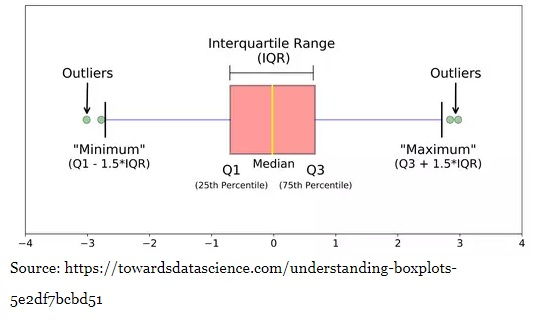

### <u>Procedure for experimental anomaly detection using IQR score</u>

<b>1) I took all the features in calculation (without any pre-feature selection) <br>
2) Feature scaling with Min-Max (becuase some of the features are sitting at different scales) <br>
3) Applied a function to calculate in evrey column (feature) <br>
4) Calculate the sum of iqr for each instance (row) ['total_iqr'] <br>
5) Sort the dataset by 'total_iqr' from highest to lowest. (The higher the score, the more abnormal) <br>
6) Label the top N (predetermined threshold * data length) rows with 'iqr_predict' label equal to 1, while the rest with 0.<br>
7) Calculate and return the precision (majority class - not fraud) and recall (minority class - fraud)

* The targets we want are high-precision on the majority class (normal transactions) and high-recall on the minority class (actually fraudulent transactions that flagged as fraudulent). There is a trade off with the false positive ratio on minority class, but the presumption is that it has a much higher cost of losing on fraudulent transactions.

In [8]:
def iqr_detection (data):
    q1,q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data > upper_bound), data,
                    np.where ((data < lower_bound), (1-data), 0)) # Giving the same magnitude to the opposite sides outlier

In [9]:
def df_iqr (df, threshold=0.0015):
    
    mms = MinMaxScaler()
    df_iqr = mms.fit_transform(df)
    df_iqr = pd.DataFrame(df_iqr, columns=df.columns)
    df_iqr = df_iqr.drop('Class', axis=1).apply(iqr_detection)    
    df_iqr['total_iqr'] = df_iqr.sum(axis=1)
    df_iqr = pd.concat([df_iqr ,df['Class']], axis=1)
    threshold = int(threshold * len(df))
    df_iqr = df_iqr.sort_values(by='total_iqr', ascending=False).reset_index()
    df_iqr.loc[:threshold, 'iqr_predict'] = 1
    df_iqr.loc[threshold:, 'iqr_predict'] = 0
    
    return round(len(df_iqr[(df_iqr['iqr_predict']==0) & (df_iqr['Class']==0)]) /len(df_iqr[df_iqr['iqr_predict']==0]),3)*100,\
           round(len(df_iqr[(df_iqr['iqr_predict']==1) & (df_iqr['Class']==1)]) /len(df_iqr[df_iqr['Class']==1]),3)*100 


In [10]:
# Set the threshold to 0.172% fraudulent transaction (as stated in the overview of the dataset) 
threshold = 0.00172
p,r = df_iqr(df, threshold)
print(f'The precision (majority class) using IQR-score in dataset is: {p}%')
print(f'The recall (minority class) using IQR-score in dataset is: {r}%')

The precision (majority class) using IQR-score in dataset is: 99.9%
The recall (minority class) using IQR-score in dataset is: 35.0%


#### Evaluate the model with multiple thresholds

In [11]:
threshold = np.arange(0.001,0.005,0.0005)
precision_recall=[np.round(df_iqr(df,i),2) for i in threshold]

In [12]:
pd.DataFrame(precision_recall,index=threshold,columns=['Precision (Class 0)','Recall (Class 1)']).rename_axis('Threshold') 

,Precision (Class 0),Recall (Class 1)
Threshold,,
0.0010,99.9,28.0
0.0015,99.9,33.1
0.0020,99.9,37.2
0.0025,99.9,40.7
0.0030,99.9,43.5
0.0035,99.9,46.1
0.0040,99.9,48.8
0.0045,99.9,51.4


### Conclusion

The results don't look so good,
but considering that we didn't use any pre-selection features at all (research for features-class relationship)
and used any hindsight information from the labeled class (except the overall dataset fraud-rate),
we can consider using this aproch as a baseline and continue to explore other ways of using this method.